In [1]:
import pickle
import pandas as pd
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, learning_curve, validation_curve, RepeatedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
with open('../models/model_regr.pkl', 'rb') as file:
    regr_outcome = pickle.load(file)
    
with open('../models/model_class.pkl', 'rb') as file:
    class_outcome = pickle.load(file)
    
df = pd.read_csv('../cleaned_data/clean_v5_fillednans.csv', delimiter=',')  

cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)

defaults = [
    'GDP per capita',
    'Social support',
    'Healthy life expectancy at birth',
    'Freedom to make life choices',
    'Generosity',
    'Perceptions of corruption',
    'Positive affect',
    'Negative affect'
]

discovered_params = [
    'Trust in government',
    'Health spending',
    'Internet access',
    'Home access to computers',
    'Average wage',
    'Poverty rate',
]

additional_params = [
    'Self-employment rate',
    'Households overcrowding',
]
# to be predicted 1. regr 2. classification
Y = df[['Happiness index']].values 
Y_bin = df[['Happy country']].values

# training data
X_basis = df[[*defaults, *discovered_params, *additional_params]]
X_extended = X_basis.values
    
# Traing/Test splits for regr and classification
X_train, X_test, Y_train, Y_test = train_test_split(X_extended, Y, test_size=0.2, random_state=41)
X_train_bin, X_test_bin, Y_train_bin, Y_test_bin = train_test_split(X_extended, Y_bin, test_size=0.2, random_state=41)

a = pd.DataFrame(Y_test_bin.flatten())
print(f"Unhappy countries in test dataset: {a.loc[a[0] == 0].count()[0]}")
print(f"Happy countries in test dataset: {a.loc[a[0] == 1].count()[0]}")

print(df.shape)

Unhappy countries in test dataset: 38
Happy countries in test dataset: 73
(555, 26)


In [3]:
model_regr = regr_outcome.best_estimator_
model_class = class_outcome.best_estimator_
model_regr

Pipeline(steps=[('scaler', StandardScaler()),
                ('estimator',
                 RandomForestRegressor(bootstrap=False, max_depth=10,
                                       max_features='log2', min_samples_leaf=3,
                                       min_samples_split=3, n_estimators=160,
                                       verbose=1))])

In [4]:
# CLASSIFICATION DIAGRAMS
Y_pred_bin = model_class.predict(X_test_bin)
print(classification_report(Y_test_bin, Y_pred_bin, target_names=['Unhappy', 'Happy']))

              precision    recall  f1-score   support

     Unhappy       0.54      0.37      0.44        38
       Happy       0.72      0.84      0.77        73

    accuracy                           0.68       111
   macro avg       0.63      0.60      0.60       111
weighted avg       0.66      0.68      0.66       111



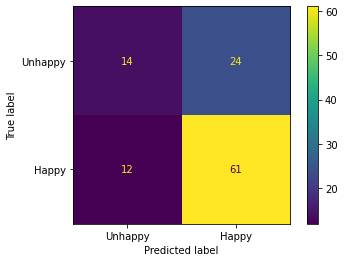

In [5]:
ConfusionMatrixDisplay.from_predictions(Y_test_bin, Y_pred_bin, display_labels=('Unhappy', 'Happy'))

In [6]:
cv_results_class = pd.DataFrame(class_outcome.cv_results_)
cv_results_class.head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split7_train_score,split8_train_score,split9_train_score,split10_train_score,split11_train_score,split12_train_score,split13_train_score,split14_train_score,mean_train_score,std_train_score
0,0.000632,0.000330,0.003286,0.000586,1,{'n_neighbors': 1},0.640449,0.595506,0.516854,0.651685,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
1,0.000476,0.000069,0.002984,0.000300,2,{'n_neighbors': 2},0.573034,0.550562,0.471910,0.483146,...,0.802817,0.785915,0.820225,0.836620,0.808451,0.814085,0.797183,0.803371,0.811191,0.017253
2,0.000473,0.000060,0.002944,0.000136,3,{'n_neighbors': 3},0.674157,0.561798,0.561798,0.640449,...,0.800000,0.788732,0.811798,0.800000,0.785915,0.811268,0.788732,0.828652,0.803864,0.015569
3,0.000472,0.000051,0.003022,0.000137,4,{'n_neighbors': 4},0.629213,0.573034,0.550562,0.595506,...,0.771831,0.743662,0.752809,0.763380,0.774648,0.763380,0.749296,0.766854,0.762956,0.012369
4,0.000491,0.000086,0.003090,0.000158,5,{'n_neighbors': 5},0.651685,0.640449,0.561798,0.640449,...,0.749296,0.723944,0.752809,0.752113,0.752113,0.743662,0.721127,0.764045,0.748872,0.013955


[Text(0.5, 0, 'Nr of neighbours'), Text(0, 0.5, 'Mean F1 test score')]

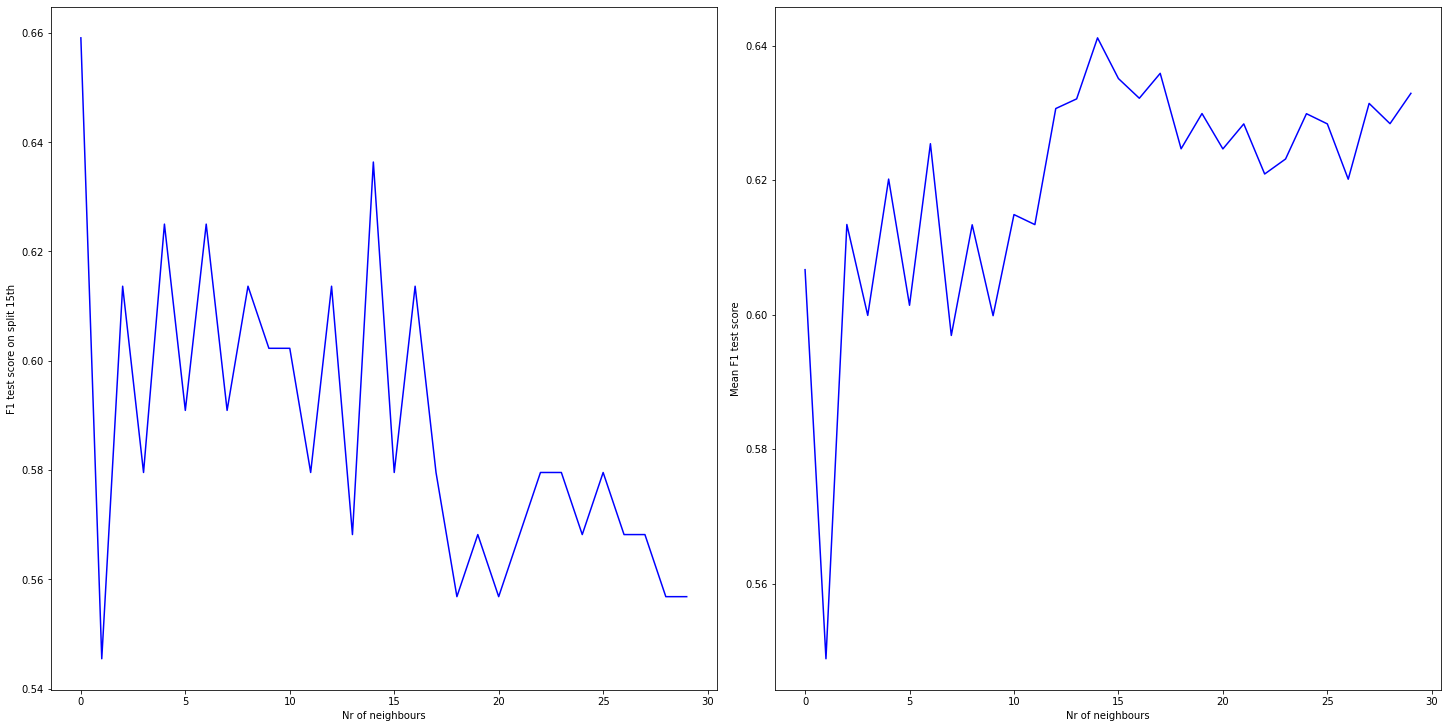

In [22]:
fig, axis = plt.subplots(1, 2, figsize=(20,10), constrained_layout = True)
axis[0].plot(range(0, cv_results_class.shape[0]), cv_results_class["split14_test_score"], c="b")
axis[0].set(xlabel="Nr of neighbours", ylabel="F1 test score on split 15th")

axis[1].plot(range(0, cv_results_class.shape[0]), cv_results_class["mean_test_score"], c="b")
axis[1].set(xlabel="Nr of neighbours", ylabel="Mean F1 test score")

In [8]:
param_range_cl=list(range(1,30))
train_scores_val_cl, test_scores_val_cl = validation_curve(
    model_class,
    X_extended,
    Y_bin,
    param_name="n_neighbors",
    param_range=param_range_cl,
    scoring="f1",
)

/Users/alicijaharaszczuk/miniforge3/envs/iaml/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/alicijaharaszczuk/miniforge3/envs/iaml/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/alicijaharaszczuk/miniforge3/envs/iaml/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/alicijaharaszczuk/miniforge3/envs/iaml/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:1

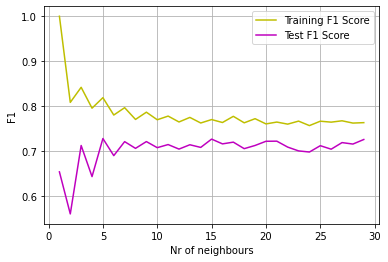

In [9]:
mean_train_score_cl = np.array([np.mean(x) for x in train_scores_val_cl])
mean_test_score_cl = np.array([np.mean(x) for x in test_scores_val_cl])
fig, ax = plt.subplots()
ax.plot(param_range_cl, mean_train_score_cl, label = "Training F1 Score", color = 'y')
ax.plot(param_range_cl, mean_test_score_cl, label = "Test F1 Score", color = 'm')
plt.grid(visible=True)
ax.set(xlabel="Nr of neighbours", ylabel="F1")
ax.legend()

In [16]:
# REGRESSION DIAGRAMS
param_range=[5, 8, 10, 12, 15]
train_scores_val, test_scores_val = validation_curve(
    model_regr,
    X_extended,
    Y,
    param_name="estimator__max_depth",
    param_range=param_range,
    cv=cv,
    scoring="neg_mean_squared_error"
)

/Users/alicijaharaszczuk/miniforge3/envs/iaml/lib/python3.9/site-packages/sklearn/pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:    0.0s finished
/Users/alicijaharaszczuk/miniforge3/envs/iaml/lib/python3.9/site-packages/sklearn/pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exa

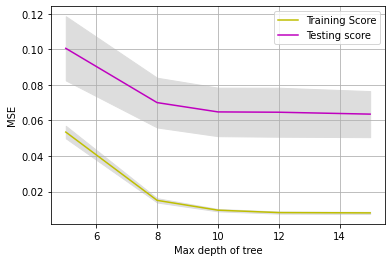

In [11]:
mean_train_score = np.mean(-train_scores_val, axis = 1)
std_train_score = np.std(-train_scores_val, axis = 1)
mean_test_score = np.mean(-test_scores_val, axis = 1)
std_test_score = np.std(-test_scores_val, axis = 1)
plt.plot(param_range, mean_train_score, label = "Training Score", color = 'y')
plt.plot(param_range, mean_test_score, label = "Testing score", color = 'm')
plt.fill_between(param_range, mean_train_score - std_train_score, mean_train_score + std_train_score, color="#DDDDDD")
plt.fill_between(param_range, mean_test_score - std_test_score, mean_test_score + std_test_score, color="#DDDDDD")
plt.grid(visible=True)
plt.xlabel("Max depth of tree")
plt.ylabel("MSE")
plt.legend()
plt.show()

In [12]:
cv_results_regr = pd.DataFrame(regr_outcome.cv_results_)
cv_results_regr.columns

Index(['iter', 'n_resources', 'mean_fit_time', 'std_fit_time',
       'mean_score_time', 'std_score_time', 'param_estimator__bootstrap',
       'param_estimator__criterion', 'param_estimator__max_depth',
       'param_estimator__max_features', 'param_estimator__min_samples_leaf',
       'param_estimator__min_samples_split', 'param_estimator__n_estimators',
       'params', 'split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'split4_test_score', 'split5_test_score',
       'split6_test_score', 'split7_test_score', 'split8_test_score',
       'split9_test_score', 'split10_test_score', 'split11_test_score',
       'split12_test_score', 'split13_test_score', 'split14_test_score',
       'mean_test_score', 'std_test_score', 'rank_test_score',
       'split0_train_score', 'split1_train_score', 'split2_train_score',
       'split3_train_score', 'split4_train_score', 'split5_train_score',
       'split6_train_score', 'split7_train_score', 'split8_train_sc

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:    0.0s finished
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[6.82814549 6.01080841 6.46421635 5.7629699  7.60345285 7.20621899
 7.39453251 7.40005702 6.17542272 7.05640222 5.96267264 6.6690997
 5.66908639 6.01881905 5.28997285 7.45816072 7.54793134 7.35988787
 5.97081668 7.24121867 6.1433788  7.48418078 6.02291707 5.80625494
 6.02205909 6.19683647 6.22623968 5.35509218 6.38717929 7.2737592
 7.06452469 6.40790074 6.34539826 7.16798704 5.41650335 5.76278853
 7.58651082 4.88578013 6.70597421 7.22126986 6.18046811 5.34468335
 6.968334   7.34933408 6.192321   5.64084603 7.21622315 7.11226718
 7.15926097 6.22073115 7.13415301 6.92471288 7.15738867 5.43625334
 5.3835737  7.10339224 5.67817268 5.60207632 4.97554857 5.96161185
 4.92504122 5.1992942  5.44703624 7.38793971 7.2616395  6.04477135
 7.35929179 6.08375273 7.54542129 4.54801916 7.32708854 6.4182149
 5.95604193 5.50536079 6.74473624 7.07655247 6.26333408 7.37654406
 7.29778776 7.61063292 6.45691968 5.65123708 6.37589827 5.33965534
 7.41832484 7.62179177 6.57183415 6.38498193 7.20231401 7.0887970

[Text(0.5, 0, 'GDP per capita'), Text(0, 0.5, 'Happiness score')]

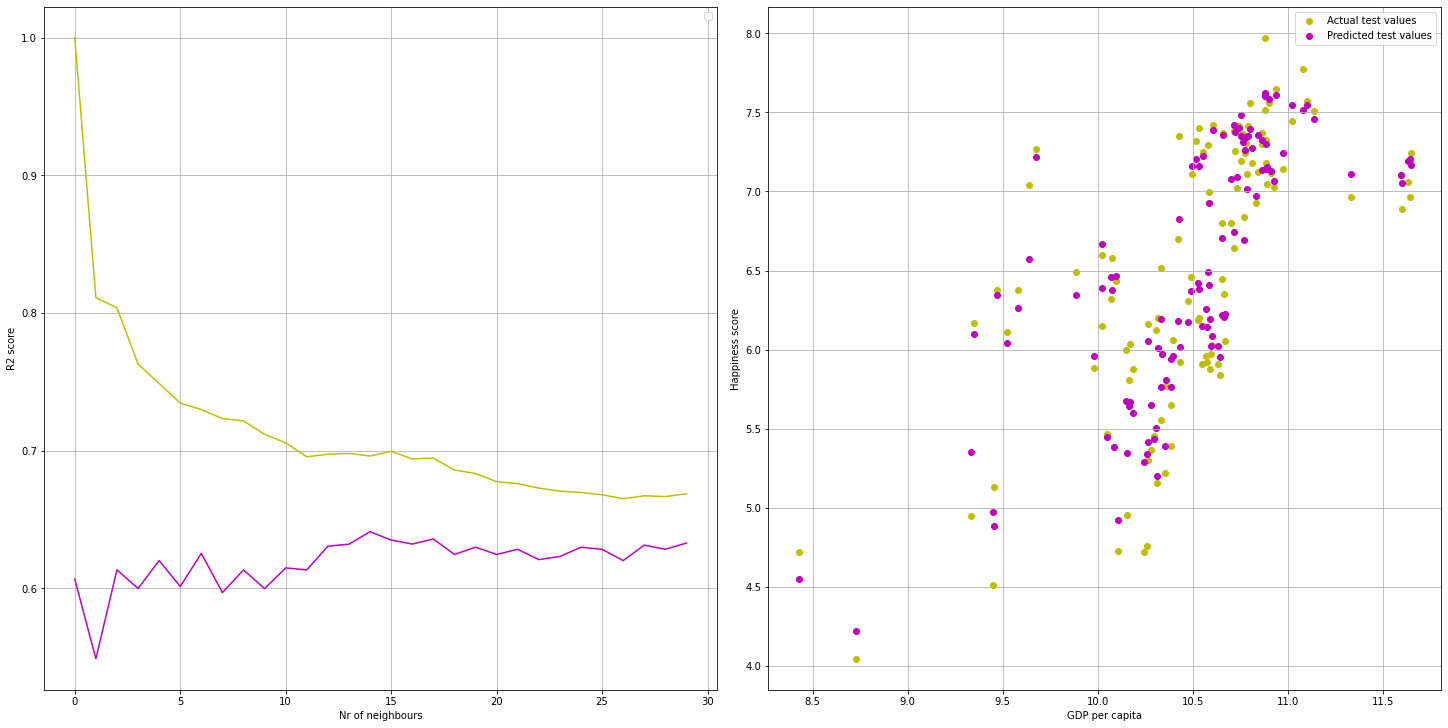

In [17]:
Y_pred = model_regr.predict(X_test)
print(Y_pred)
fig, axis = plt.subplots(1, 2, figsize=(20,10), constrained_layout = True)
axis[0].plot(range(0, cv_results_class.shape[0]), cv_results_class["mean_test_score"], c="m")
axis[0].plot(range(0, cv_results_class.shape[0]), cv_results_class["mean_train_score"], c="y")
axis[0].grid(visible=True)
axis[0].legend()
axis[0].set(xlabel="Nr of neighbours", ylabel="R2 score")

axis[1].scatter(X_test[:, 0], Y_test, c="y", label="Actual test values")
axis[1].scatter(X_test[:, 0], Y_pred, c="m", label="Predicted test values")
plt.xticks()
plt.yticks()
axis[1].grid(visible=True)
axis[1].legend()
axis[1].set(xlabel="GDP per capita", ylabel="Happiness score")

In [14]:
print(model_regr.named_steps['estimator'])

RandomForestRegressor(bootstrap=False, max_depth=10, max_features='log2',
                      min_samples_leaf=3, min_samples_split=3, n_estimators=160,
                      verbose=1)


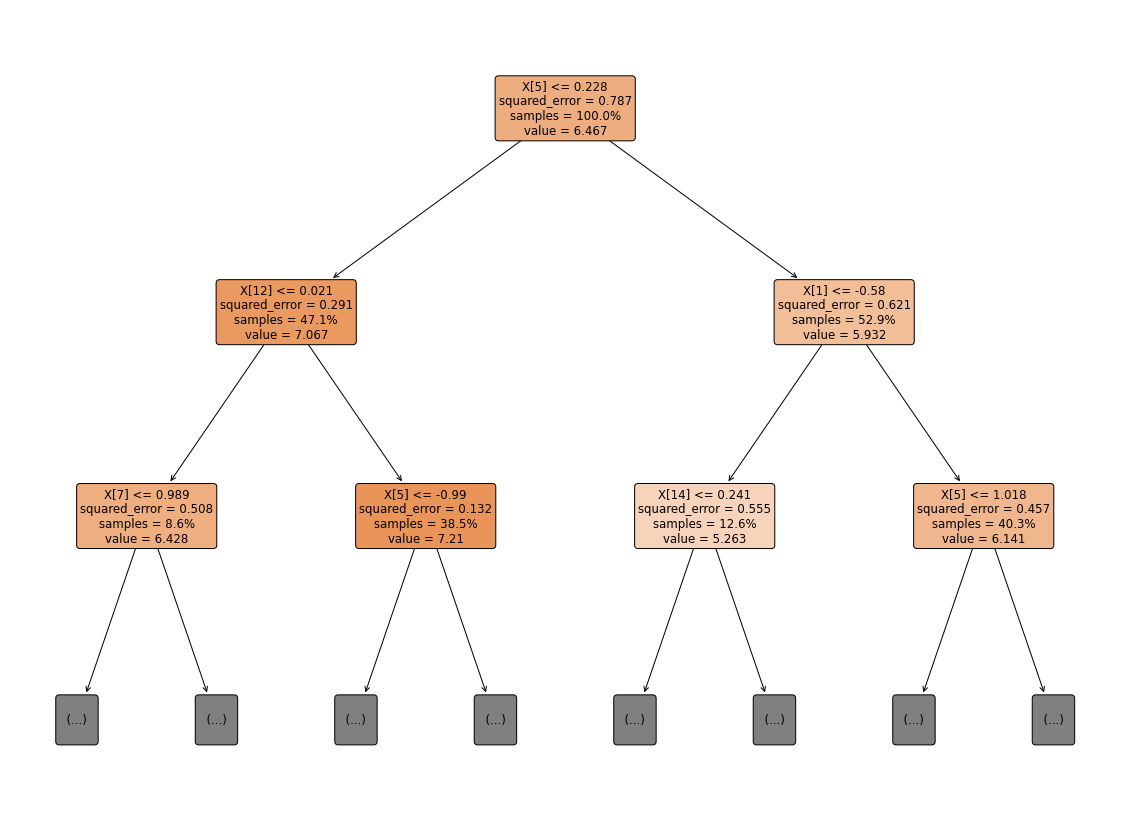

In [15]:
from sklearn import tree
plt.figure(figsize=(20,15))
tree.plot_tree(model_regr.named_steps['estimator'][0], max_depth=2, filled=True, impurity=True, rounded=True, proportion=True)
plt.show()